# Compute heights using number of levels times some selceted constant

According to [1] the most used constants as level heights are between 2.8m and 3.5m, but we tried more (from 2.4m to 4.3m).
Before testing any constant, we first try the average of level heights as a potential constant (which we learn from available data, i.e., divide height by number of levels and then return the average).

[1] Biljecki, Filip, Hugo Ledoux, and Jantien Stoter. "Generating 3D city models without elevation data." Computers, Environment and Urban Systems 64 (2017): 1-18.

### Import data from Open Street Map using boundaries of the selected German city (HALLE):
Boundaries --> https://www.openstreetmap.org/export#map=12/51.4729/11.9724&layers=D

In [1]:
import math
import numpy as np
import osmnx as ox
import utm
from typing import List

south, east, north, west = 51.3435, 12.5023, 51.6020, 11.4419

#Get building data from open street map.
buildings = ox.geometries_from_bbox(north, south, east, west, tags={'building': True})

data = buildings
data.head()

C:\Users\bbel\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


entrance                   geometry wheelchair  \
element_type osmid                                                      
node         288798170      NaN  POINT (12.09269 51.38702)         no   
             415265417      NaN  POINT (12.31967 51.37029)        yes   
             442150170      NaN  POINT (11.52240 51.51803)        NaN   
             502399091      NaN  POINT (11.72556 51.49072)        NaN   
             918346410      NaN  POINT (12.33702 51.37445)        NaN   

                           amenity height width level created_by access  \
element_type osmid                                                        
node         288798170         NaN     15   NaN   NaN        NaN    NaN   
             415265417         NaN    NaN   NaN   NaN        NaN    NaN   
             442150170         NaN    NaN   NaN   NaN        NaN    NaN   
             502399091  restaurant    NaN   NaN   NaN        NaN    NaN   
             918346410         NaN    NaN   NaN   NaN        NaN    NaN   

                       barrier  ... depth resource ways old_name2  \
element_type osmid              ...                                 
node         288798170     NaN  ...   NaN      NaN  NaN       NaN   
             415265417     NaN  ...   NaN      NaN  NaN       NaN   
             442150170     NaN  ...   NaN      NaN  NaN       NaN   
             502399091     NaN  ...   NaN      NaN  NaN       NaN   
             918346410   fence  ...   NaN      NaN  NaN       NaN   

                       monument:genesis ebusinesslotse ebusinesslotse:profil  \
element_type osmid                                                             
node         288798170              NaN            NaN                   NaN   
             415265417              NaN            NaN                   NaN   
             442150170              NaN            NaN                   NaN   
             502399091              NaN            NaN                   NaN   
             918346410              NaN            NaN                   NaN   

                       ebusinesslotse:role ebusinesslotse:url rail  
element_type osmid                                                  
node         288798170                 NaN                NaN  NaN  
             415265417                 NaN                NaN  NaN  
             442150170                 NaN                NaN  NaN  
             502399091                 NaN                NaN  NaN  
             918346410                 NaN                NaN  NaN  

[5 rows x 634 columns]

### Statistics

In [2]:
size = len(data)
heights = len(data[~data['height'].isna()])
levels = len(data[~data['building:levels'].isna()])
heights_levels = len(data[~data['building:levels'].isna() & ~data['height'].isna()])
print("Number of buildings: ", size)
print("Available Heights: ", heights, "(", 100*heights/size,"%)")
print("Available Levels: ", levels, "(", 100*levels/size,"%)")
print("Available Heights & Levels: ", heights_levels, "(", 100*heights_levels/size,"%)")

Number of buildings:  233680
Available Heights:  1282 ( 0.5486134885313249 %)
Available Levels:  20136 ( 8.616912016432728 %)
Available Heights & Levels:  853 ( 0.3650290996234166 %)


 ### Convert building levels from String to Float
Problem: it depends on the region/language, e.g., RC means level 0 in French

In [3]:
data['building:levels'] = data['building:levels'].str.replace(';', '')
data['building:levels'] = data['building:levels'].str.replace(',', '')
data['building:levels'] = data['building:levels'].str.replace('RC', '0')
data['building:levels'] = data['building:levels'].str.replace('Erdgeschoss und 2. Etage', '2')
data['building:levels'] = data['building:levels'].str.replace('s', '0')
data['building:levels'] = data['building:levels'].str.replace('3 - 4', '4').astype(float)

C:\Users\bbel\AppData\Local\Temp\ipykernel_24020\2464060021.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data['building:levels'] = data['building:levels'].str.replace('Erdgeschoss und 2. Etage', '2')


### Convert height from String to Float

In [4]:
data['height'] = data['height'].str.replace(',', '.')
data['height'] = data['height'].str.replace('~', '')
data['height'] = data['height'].str.replace('m', '').astype(float)

### Update the number of levels
For most countries ground floor = 0 --> increment number of floors by 1

In [5]:
data['building:levels'] = data['building:levels'] + 1

### Compute level height using available data

In [6]:
data['LevelHeight'] = data['height'] / data['building:levels']

### Find the optimal constant, for which the error is minimized
MAE: Mean Absolute Error

RMSE: Root Mean Squared Error

In [7]:
#First constant: Compute height using the mean as constant
data['heightComputed'] = data['building:levels'] * data['LevelHeight'].mean()
data['Distance'] = abs(data['height'] - data['heightComputed'])
data['Distance*2'] = (data['height'] - data['heightComputed']) ** 2
subData = data[~data['Distance'].isna()]
print('------------------------*MEAN-----------------------------')
error = subData['Distance'].sum() / len(subData)
error2 = math.sqrt(subData['Distance*2'].sum() / len(subData))
print('Constant: ', data['LevelHeight'].mean(), 'm')
print('MAE: ', error, 'm')
print('RMSE: ', error2, 'm')
print('Min: ', subData['Distance'].min())
print('Max: ', subData['Distance'].max())

#Height = Constant* Building:levels
constant = 1.0
Optconstant = data['LevelHeight'].mean()
OptError = error
OptError2 = error2
# Try 50 constants and select the one that yields the best Mean Absolute Error
for i in range(50):
    data['heightComputed'] = data['building:levels'] * constant
    data['Distance'] = abs(data['height'] - data['heightComputed'])
    data['Distance*2'] = (data['height'] - data['heightComputed'])**2
    subData = data[~data['Distance'].isna()]

    error = subData['Distance'].sum() / len(subData)
    error2 = math.sqrt(subData['Distance*2'].sum() / len(subData))
    if error < OptError:
        OptError = error
        Optconstant = constant
        OptError2 = error2
    constant = constant + 0.1

print('------------------------OPT-----------------------------')
print('Constant: ', Optconstant, 'm')
print('MAE: ', OptError, 'm')
print('RMSE: ', OptError2, 'm')

------------------------*MEAN-----------------------------
Constant:  2.5063137845994206 m
MAE:  3.0408470177789217 m
RMSE:  4.328916005595225 m
Min:  0.012627569198841115
Max:  38.96211729240348
------------------------OPT-----------------------------
Constant:  3.0000000000000018 m
MAE:  2.7162016412661205 m
RMSE:  3.4456847981234073 m


### Use the optimal constant to compute building heights
Probelm: we have only 8% of buildings with available heights, these are the only on which we can compute hights  

In [8]:
data['heightComputed'] = data['building:levels'] * Optconstant

In [9]:
len(data[~data['heightComputed'].isna()])

20136

### Clip into the administrative boundary

In [10]:
import geopandas as gpd
border = gpd.read_file('halle.geojson')
final = gpd.clip(data, border)

### Save into a GeoJason file as vector data 

In [11]:
cols = ['geometry', 'building', 'building:levels', 'height', 'heightComputed'] 
final = final[cols]
with open('halle_method1.geojson' , 'w') as file:
    file.write(final.to_json())  

<AxesSubplot: >

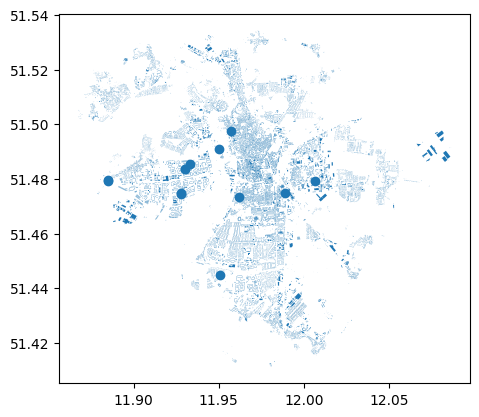

In [12]:
final.plot()

### Stats

In [13]:
print("Number of buildings: ", len(final))
print("Computed heights: ", len(final[~final['heightComputed'].isna()])) 

Number of buildings:  40636
Computed heights:  8440


In [17]:
final.head()

geometry  \
element_type osmid                                                          
way          171862503  POLYGON ((11.97736 51.42796, 11.97744 51.42793...   
             171862477  POLYGON ((11.97698 51.42797, 11.97695 51.42794...   
             171862465  POLYGON ((11.97703 51.42804, 11.97712 51.42802...   
             171862496  POLYGON ((11.97694 51.42807, 11.97703 51.42804...   
             171862489  POLYGON ((11.97673 51.42813, 11.97682 51.42810...   

                       building  building:levels  height  heightComputed  
element_type osmid                                                        
way          171862503      yes              NaN     NaN             NaN  
             171862477      yes              NaN     NaN             NaN  
             171862465      yes              NaN     NaN             NaN  
             171862496      yes              NaN     NaN             NaN  
             171862489      yes              NaN     NaN             NaN

In [18]:
data.head()

entrance                   geometry wheelchair  \
element_type osmid                                                      
node         288798170      NaN  POINT (12.09269 51.38702)         no   
             415265417      NaN  POINT (12.31967 51.37029)        yes   
             442150170      NaN  POINT (11.52240 51.51803)        NaN   
             502399091      NaN  POINT (11.72556 51.49072)        NaN   
             918346410      NaN  POINT (12.33702 51.37445)        NaN   

                           amenity  height width level created_by access  \
element_type osmid                                                         
node         288798170         NaN    15.0   NaN   NaN        NaN    NaN   
             415265417         NaN     NaN   NaN   NaN        NaN    NaN   
             442150170         NaN     NaN   NaN   NaN        NaN    NaN   
             502399091  restaurant     NaN   NaN   NaN        NaN    NaN   
             918346410         NaN     NaN   NaN   NaN        NaN    NaN   

                       barrier  ... monument:genesis ebusinesslotse  \
element_type osmid              ...                                   
node         288798170     NaN  ...              NaN            NaN   
             415265417     NaN  ...              NaN            NaN   
             442150170     NaN  ...              NaN            NaN   
             502399091     NaN  ...              NaN            NaN   
             918346410   fence  ...              NaN            NaN   

                       ebusinesslotse:profil ebusinesslotse:role  \
element_type osmid                                                 
node         288798170                   NaN                 NaN   
             415265417                   NaN                 NaN   
             442150170                   NaN                 NaN   
             502399091                   NaN                 NaN   
             918346410                   NaN                 NaN   

                       ebusinesslotse:url rail LevelHeight heightComputed  \
element_type osmid                                                          
node         288798170                NaN  NaN         NaN            NaN   
             415265417                NaN  NaN         NaN            NaN   
             442150170                NaN  NaN         NaN            NaN   
             502399091                NaN  NaN         NaN            NaN   
             918346410                NaN  NaN         NaN            NaN   

                       Distance Distance*2  
element_type osmid                          
node         288798170      NaN        NaN  
             415265417      NaN        NaN  
             442150170      NaN        NaN  
             502399091      NaN        NaN  
             918346410      NaN        NaN  

[5 rows x 638 columns]

### Convert vector data to raster data and save as a Tiff file
PS: I had to lower the resolution to 0.0001 to get the complete data!

In [90]:
from geocube.api.core import make_geocube
out_grid = make_geocube(vector_data=final, measurements=['heightComputed'] , resolution=(0.0001, -0.0001))

In [92]:
out_grid['heightComputed'].rio.to_raster('halle_method1_raster.tiff')